In [92]:
#Import libraries
import pandas as pd
import numpy as np
import mysql.connector as mysql
import json

import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, acf

# 1. Getting the Data

In [5]:
#Connect to the DB
with open('credentials.json') as file:
    credentials = json.load(file)
    
conn = mysql.connect(
    host=credentials['host'],
    user=credentials['user'],
    password=credentials['password']
)

In [6]:
#Query stocks prices from table
stock_query = '''
select 
    Date,
    Ticker,
    Open,
    High,
    Low,
    Close,
    AdjClose,
    Volume
from stocks.daily_stock_prices;
'''

stocks_df = pd.read_sql(stock_query, conn)

/home/edilson/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
#Splitting up the data by stock
stocks_dict = {
    ticker: stocks_df[stocks_df['Ticker'] == ticker].drop(columns = 'Ticker') 
    for ticker in stocks_df['Ticker'].unique()
}

# 2. Initial Exploration

In [69]:
#Setting up graph configurations
pio.templates.default = 'plotly_white'

color_map = {
    'Open': '#404c85',
    'High': '#36822c',
    'Low': '#81d975',
    'Close': '#d15845',
    'AdjClose': '#eb7b6a',
    'Volume': '#919191'
}

In [39]:
#Define plot functions
def plot_stocks(data, ticker, highlight_series=None):
    '''
    Plot two graphs for the selected stock:
    1. Stock prices (Open, High, Low, Close and AdjClose)
    2. Volume of stocks traded
    '''
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=('Stock Prices', 'Trade Volume'),
        column_widths=[0.6, 0.4]
    )
    
    #Plot stock prices
    stock_price_cols = ['Open', 'High', 'Low', 'Close', 'AdjClose']
    for col in stock_price_cols:
        if highlight_series != None:
            opacity = 1 if col in highlight_series else 0.1
        else:    
            opacity = 1
        
        fig.add_trace(go.Scatter(
            x=data[ticker]['Date'], 
            y=data[ticker][col],
            name=col,
            marker_color=color_map[col],
            opacity=opacity
        ),
        row=1,
        col=1
    )
   
    #Plot volume of stocks traded
    fig.add_trace(go.Scatter(
            x=data[ticker]['Date'], 
            y=data[ticker]['Volume'],
            name='Volume',
            marker_color=color_map['Volume']
        ),
        row=1,
        col=2
    )
    fig.update_layout(title_text=ticker)
    fig.show()

In [40]:
#Plot AMZN
plot_stocks(stocks_dict, 'AMZN', ['Open'])

In [42]:
#Plot UNH
plot_stocks(stocks_dict, 'UNH', ['Open'])

In [43]:
#Plot XOM
plot_stocks(stocks_dict, 'XOM', ['Open'])

In [44]:
#Plot CVS
plot_stocks(stocks_dict, 'CVS', ['Open'])

In [45]:
#Plot AAPL
plot_stocks(stocks_dict, 'AAPL', ['Open'])

In [46]:
#Plot GOOG
plot_stocks(stocks_dict, 'GOOG', ['Open'])

In [47]:
#Plot ABC
plot_stocks(stocks_dict, 'ABC', ['Open'])

In [48]:
#Plot WMT
plot_stocks(stocks_dict, 'WMT', ['Open'])

In [49]:
#Plot BRK-B
plot_stocks(stocks_dict, 'BRK-B', ['Open'])

In [53]:
#Plot MCK
plot_stocks(stocks_dict, 'MCK', ['Open'])

On the graphs above, we highlighted the daily opening stock prices and the trade volume. For each stock, some trend can be seen for both variables. However, there is not much more we can take from those plots.

The next step is to understand how we are going to predict stock prices for the following days. As in the plots, we are going to focus on the "Open" value. For this analysis, no additional information we'll be used, such news or socia media data. As such, there are 3 points we can further explore:

* How the current value relates to data from previous dates;
* How the other fields correlate to the "Open" stock price;
* How the "Volume" field correlates do "Open".

# 3. Understanding Relationships

## 3.1. "Open" Autocorrelation

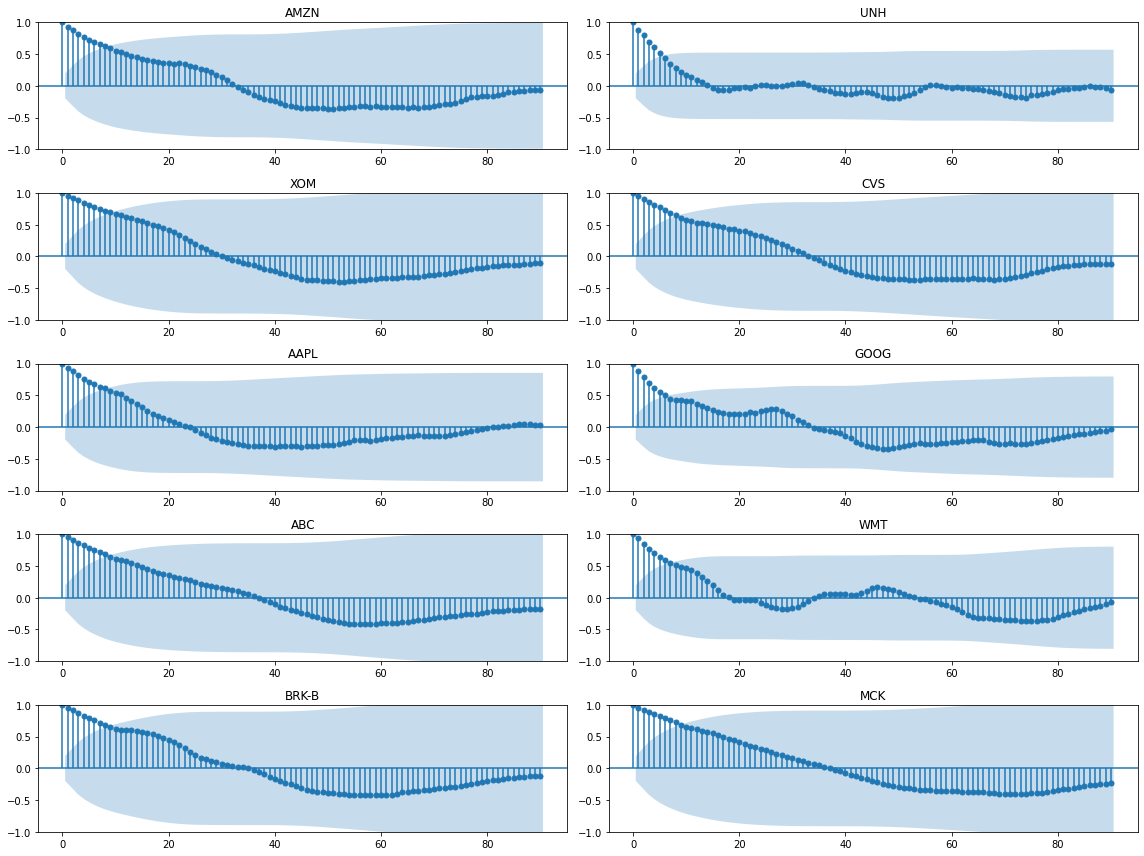

In [108]:
#Plot the autocorrelation for 80 lags
fig, ax = plt.subplots(5, 2, figsize=(16,12))

for i, ticker in enumerate(stocks_dict.keys()):
    row, col = divmod(i, 2)
    
    plot_acf(
        x=stocks_dict[ticker]['Open'].values, 
        lags=90,
        title=ticker,
        alpha=0.05,
        ax=ax[row, col]
    )

fig.tight_layout()
plt.show()

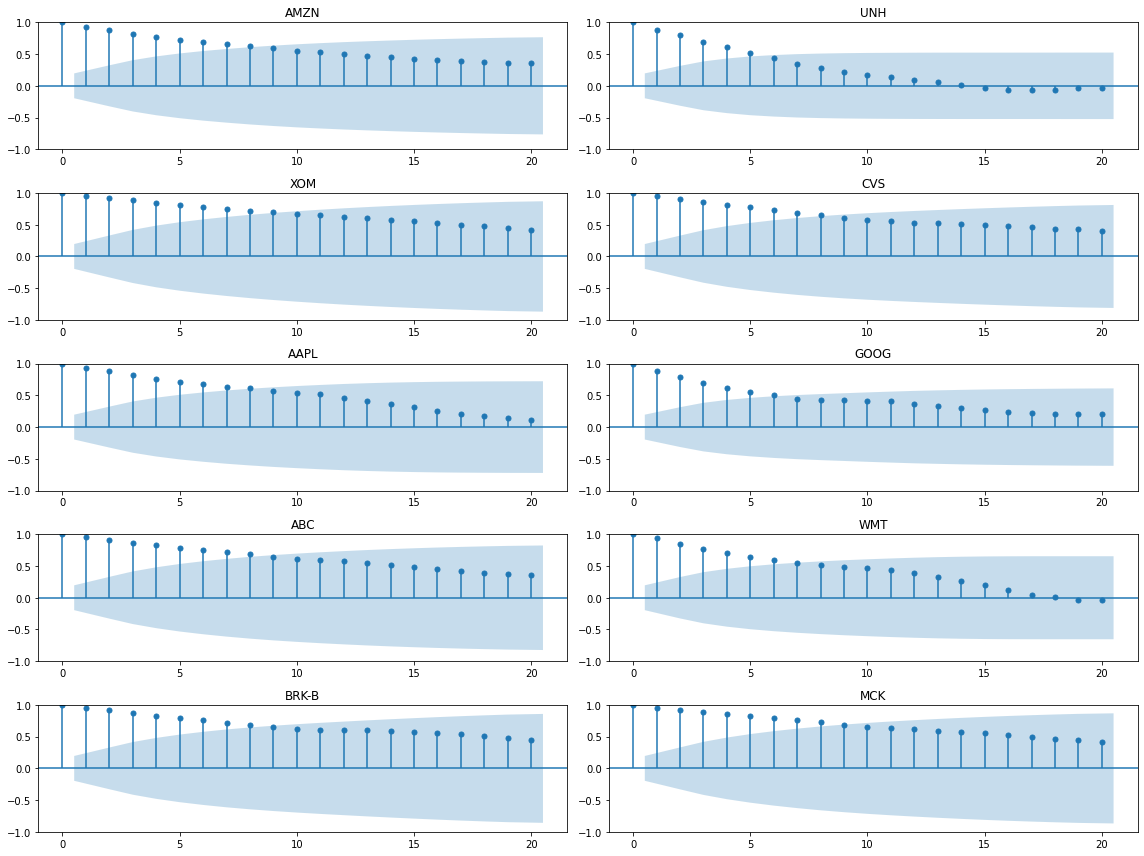

In [106]:
#Plot the autocorrelation for 20 lags
fig, ax = plt.subplots(5, 2, figsize=(16,12))

for i, ticker in enumerate(stocks_dict.keys()):
    row, col = divmod(i, 2)
    
    plot_acf(
        x=stocks_dict[ticker]['Open'].values, 
        lags=20,
        title=ticker,
        alpha=0.05,
        ax=ax[row, col]
    )

fig.tight_layout()
plt.show()

We plotted the autocorrelation for two lag ranges, 90 and 20. The first one is intended to gives us a broader sense of how the current stock prices have little to do with how they performed 1 or 2 months before. As for the second set of graphs, the idea is to focus on the very short-term, where we can find some relevant correlations. Another thing we can observe as how each stock behaves in a slightly different way. 

This gives us an indication some adjustment should be made when predicting each stock price. This information will be useful for us later on.